In [ ]:
# 사용자 정의 모델과 훈련

In [ ]:
# 후버 손실

In [ ]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

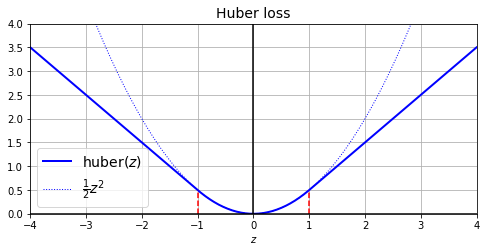

In [ ]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()


In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)


In [ ]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))


Epoch 1/2
363/363 [==============================] - 4s 5ms/step - loss: 0.6415 - mae: 1.0104 - val_loss: 0.2217 - val_mae: 0.5185
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.2077 - mae: 0.5025 - val_loss: 0.2214 - val_mae: 0.5099


In [ ]:
# 사용자 정의 요소를 가진 모델의 저장/로드

In [ ]:
# loss가 줄고 있음

In [ ]:
model.save("my_model_with_a_custom_loss.h5")
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))


Epoch 1/2
363/363 [==============================] - 2s 5ms/step - loss: 0.1995 - mae: 0.4896 - val_loss: 0.1902 - val_mae: 0.4797
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.1964 - mae: 0.4848 - val_loss: 0.1854 - val_mae: 0.4683


In [ ]:
# 구간을 매개변수로

In [ ]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn


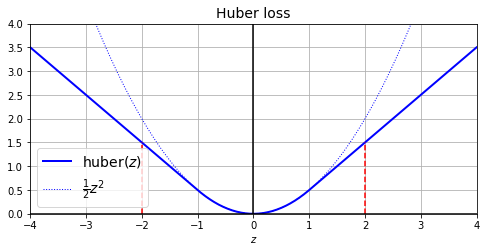

In [ ]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-2, -2], [0, huber_fn(0., -2.)], "r--")
plt.plot([2, 2], [0, huber_fn(0., 2.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.save("my_model_with_a_custom_loss_threshold_2.h5")


Epoch 1/2
363/363 [==============================] - 5s 9ms/step - loss: 0.2180 - mae: 0.4838 - val_loss: 0.2030 - val_mae: 0.4730
Epoch 2/2
363/363 [==============================] - 3s 9ms/step - loss: 0.2145 - mae: 0.4794 - val_loss: 0.2149 - val_mae: 0.4664


In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))


Epoch 1/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2120 - mae: 0.4768 - val_loss: 0.1962 - val_mae: 0.4528
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2091 - mae: 0.4715 - val_loss: 0.2179 - val_mae: 0.4663


In [ ]:
# 이러한 문제는 keras.losses.Loss클래스를 상속하고 get_config()메서드를 구현하여 해결할 수 있다.

In [ ]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.save("my_model_with_a_custom_loss_class.h5")

Epoch 1/2
363/363 [==============================] - 4s 7ms/step - loss: 1.0484 - mae: 1.0925 - val_loss: 0.2542 - val_mae: 0.5259
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2442 - mae: 0.5225 - val_loss: 0.2537 - val_mae: 0.5107


In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 4s 8ms/step - loss: 0.2321 - mae: 0.5081 - val_loss: 0.2229 - val_mae: 0.4978
Epoch 2/2
363/363 [==============================] - 2s 6ms/step - loss: 0.2280 - mae: 0.5032 - val_loss: 0.2778 - val_mae: 0.5229


In [ ]:
model.loss.threshold

2.0

In [ ]:
# 활성화 함수, 초기화, 규제, 제한을 사용자화 하기

In [ ]:
def my_softplus(z): # tf.nn.softplus(z) 값을 반환합니다
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1])) # (fan-in + fain-out) / 2
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # tf.nn.relu(weights) 값을 반환합니다
    return tf.where(weights < 0., tf.zeros_like(weights), weights)


In [ ]:
# 만들어진 사용자 정의 함수는 보통의 함수화 동일하게 다음과 같이 사용

In [ ]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)


In [ ]:
# 활성화 함수는 Dense 출력층에 적용
# 가중치는 초기화 함수에서 반환된 값으로 초기화
# 훈련 스텝마다 가중치가 규제 함수에 전달되어 규제 손실 계산하여, 전체 손실에 추가 되어 최종 손실을 만듦
# 제한 함수가 훈련 스텝마다 층의 가중치를 제한한 가중치 값으로 바꿈

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])


In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))


Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 1.5396 - mae: 0.8751 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.6142 - mae: 0.5118 - val_loss: inf - val_mae: inf


In [ ]:
model.save("my_model_with_many_custom_parts.h5")


In [ ]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })


In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))


Epoch 1/2
363/363 [==============================] - 2s 5ms/step - loss: 0.5595 - mae: 0.4960 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.5306 - mae: 0.4915 - val_loss: inf - val_mae: inf


In [ ]:
# factor 하이퍼파라미터를 저장하는 L1규제를 위한 간단한 클래스 예

In [ ]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}


In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))


Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 1.9416 - mae: 0.9437 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.7101 - mae: 0.5494 - val_loss: inf - val_mae: inf


In [ ]:
model.save("my_model_with_many_custom_parts.h5")


In [ ]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2, validation_data=(X_valid_scaled, y_valid))


Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 0.5862 - mae: 0.5118 - val_loss: 2.8643 - val_mae: 0.5223
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.5228 - mae: 0.4956 - val_loss: 2.1826 - val_mae: 0.5038
